In [1]:
from joblib import load
import numpy as np
import matplotlib.pyplot as plt

In [2]:
importance = load('../data/elec2_inc/importance.joblib')

In [3]:
arange = 150
difference = load('../data/elec2_inc/difference.joblib')[:arange]
cum = np.cumsum(difference)[:arange]
x = np.arange(arange)

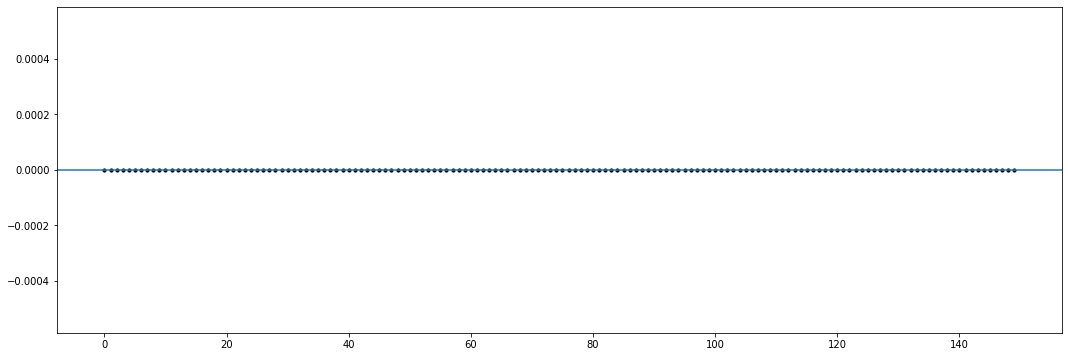

In [4]:
plt.figure(figsize=(18, 6))
plt.fill_between(x, cum, 0)
plt.scatter(x, difference, s=10, c='black')
plt.axhline(0)

In [5]:
print(cum[-10:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
with open('../elec2_noninc.output') as fin:
    print(fin.read())

[FINETUNING BASE MODELS]
[GENERATE METAFEATURE]
Frequency statistics in metabase:
	SVC                      0.530
	RandomForestClassifier   0.400
	GaussianNB               0.070
[OFFLINE LEARNING]
Kappa:    0.119
GMean:    0.242
Accuracy: 0.533
[[105  54   0]
 [ 62  54   4]
 [  8  12   1]]
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       159
           1       0.45      0.45      0.45       120
           2       0.20      0.05      0.08        21

    accuracy                           0.53       300
   macro avg       0.42      0.39      0.39       300
weighted avg       0.51      0.53      0.52       300

                   pre       rec       spe        f1       geo       iba       sup

          0       0.60      0.66      0.50      0.63      0.58      0.34       159
          1       0.45      0.45      0.63      0.45      0.53      0.28       120
          2       0.20      0.05      0.99      0.08      0.22      0.04      